# Phrases

Process the phrases that appear in a relation.

In [20]:
import copy
import json
import pandas as pd
import re

## 1. Read the data

In [21]:
DATA_FILE = "../data/femke.jsonl"

In [22]:
json_data = []
infile = open(DATA_FILE, "r")
for line in infile:
    json_data.append(json.loads(line))
infile.close()

In [23]:
len(json_data)

1867

## 2. Give an example of the data

In [24]:
json_data[0]

{'id': 6660,
 'data': 'Today I want to send a clear message to the people of this great country, of Greece. I know that many people feel without hope. Many are making extremely difficult sacrifices. And many people ask why they should do more. I understand those concerns. And I agree that some of the efforts seem unfair. But I ask people to recognise the other alternatives which will be much more difficult for Greece and will affect even more the most vulnerable in the Greek society. So this is why it is the right approach to ask Greece to reform, to increase its competitiveness to have a viable future, irrespective of the crisis. You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece. And the best hope of a return to growth and job creation is inside the euro area. Staying in the euro is the best chance to avoid worse hardship and difficulties to the Greek people, namely for those in 

## 3. Count the frequency of the labels in each data item

In [25]:
def get_patterns(json_data):
    base_cases = []
    results = {}
    for data in json_data:
        key = [0, 0, 0]
        for label in data["label"]:
            if label[2] == 'Content_Concept_1':
                key[0] += 1
            elif label[2] == 'Content_Relation_Explanation':
                key[1] += 1
            elif label[2] == 'Content_Concept_2':
                key[2] += 1
            else:
                print("cannot happen")
        for i in range(0, len(key)):
            key[i] = str(key[i])
        results_key = " ".join(key)
        if not results_key in results:
            results[results_key] = 1
        else:
            results[results_key] += 1
        if results_key == "1 1 1":
             base_cases.append(data)
    return [results, base_cases]

results, base_cases = get_patterns(json_data)
print(results)

{'1 1 1': 1400, '2 1 1': 230, '1 1 2': 136, '2 1 2': 24, '1 2 1': 2, '1 0 0': 3, '1 1 0': 5, '0 1 1': 5, '3 1 1': 30, '1 1 3': 13, '2 1 0': 3, '4 1 1': 4, '0 1 3': 1, '3 1 2': 3, '2 1 3': 3, '5 1 1': 1, '1 1 4': 1, '4 1 2': 3}


Some data items have more than two content concepts because of split phrases.

## 4. Convert base cases (1,1,1) to table

In [26]:
len(base_cases)

1400

In [27]:
base_cases[0]

{'id': 6660,
 'data': 'Today I want to send a clear message to the people of this great country, of Greece. I know that many people feel without hope. Many are making extremely difficult sacrifices. And many people ask why they should do more. I understand those concerns. And I agree that some of the efforts seem unfair. But I ask people to recognise the other alternatives which will be much more difficult for Greece and will affect even more the most vulnerable in the Greek society. So this is why it is the right approach to ask Greece to reform, to increase its competitiveness to have a viable future, irrespective of the crisis. You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece. And the best hope of a return to growth and job creation is inside the euro area. Staying in the euro is the best chance to avoid worse hardship and difficulties to the Greek people, namely for those in 

In [28]:
table = []
for data_in in base_cases:
    data_out = [data_in["data"], "", "", ""]
    for label_data in data_in["label"]:
        data_out_id = -1
        if label_data[2] == 'Content_Concept_1':
            data_out_id = 1
        elif label_data[2] == 'Content_Relation_Explanation':
            data_out_id = 2
        elif label_data[2] == 'Content_Concept_2':
            data_out_id = 3
        else:
            print(f"unexpected label data: {label_data}")
        if data_out[data_out_id] != "":
            print("duplicate data in label_data: {data_in['label']}")
        data_out[data_out_id] = data_in["data"][label_data[0]:label_data[1]]
    table.append(data_out)

In [29]:
table[0]

['Today I want to send a clear message to the people of this great country, of Greece. I know that many people feel without hope. Many are making extremely difficult sacrifices. And many people ask why they should do more. I understand those concerns. And I agree that some of the efforts seem unfair. But I ask people to recognise the other alternatives which will be much more difficult for Greece and will affect even more the most vulnerable in the Greek society. So this is why it is the right approach to ask Greece to reform, to increase its competitiveness to have a viable future, irrespective of the crisis. You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece. And the best hope of a return to growth and job creation is inside the euro area. Staying in the euro is the best chance to avoid worse hardship and difficulties to the Greek people, namely for those in a more vulnerable pos

In [30]:
pd.DataFrame(table, columns=["Paragraph", "Content_Concept_1", "Content_Relation_Explanation", "Content_Concept_2"])

,Paragraph,Content_Concept_1,Content_Relation_Explanation,Content_Concept_2
0,Today I want to send a clear message to the pe...,"You, in Greece, with our support, need to rebu...",to,increase the competitiveness of Greece
1,Today I want to send a clear message to the pe...,"You, in Greece, with our support, need to rebu...",And the best hope of a,return to growth
2,"To conclude, let me say a few words on the eur...","We have taken important, fundamental decisions",to safeguard,the stability of the euro area
3,"To conclude, let me say a few words on the eur...",We need sustained efforts and determination,As we said there will not be,magic solutions
4,Giving to the ECB the ultimate responsibility ...,confidence between the banks,and in this way,increase the financial stability in the euro area
...,...,...,...,...
1395,But today I want to focus on our economic prio...,cut business taxes,You've got to,succeed
1396,But today I want to focus on our economic prio...,tackle the bloat in welfare,You've got to,succeed
1397,But today I want to focus on our economic prio...,make sure your schools and your universities a...,and crucially you've got to,succeed
1398,Now yesterday I gave a speech setting out the ...,When you have a single currency,you move inexorably towards,a banking union


## 5. Combine all data of duplicate paragraps

In [31]:
combined_data = {}
for data in json_data:
    key = f"{data['source_id']} {data['speech_id']} {data['paragraph_id']}"
    if key not in combined_data:
        combined_data[key] = copy.deepcopy(data)
    else:
        if len(data["data"]) != len(combined_data[key]["data"]):
            print("cannot happen")
        for label_data in data["label"]:
            if label_data not in combined_data[key]["label"]:
                combined_data[key]["label"].append(label_data)
                if combined_data[key]["label"][-1][1] > len(combined_data[key]["data"]):
                    combined_data[key]["label"][-1][1] = len(combined_data[key]["data"])

for key in combined_data:
    for label_data in combined_data[key]["label"]:
        label_data.append(combined_data[key]["data"][label_data[0]:label_data[1]])

In [32]:
len(combined_data)

526

In [33]:
results, base_cases = get_patterns(list(combined_data.values()))
print(results)

{'5 2 4': 3, '2 2 2': 52, '1 1 1': 95, '3 2 3': 10, '3 2 2': 24, '5 3 3': 3, '5 2 2': 6, '5 4 6': 5, '4 3 3': 5, '1 2 2': 5, '8 2 4': 1, '2 3 3': 1, '8 5 8': 1, '2 1 1': 30, '1 1 2': 22, '3 3 3': 15, '2 1 2': 8, '9 5 6': 1, '3 3 4': 8, '3 1 2': 5, '2 2 6': 4, '4 2 2': 11, '3 1 1': 12, '4 2 3': 8, '8 3 4': 2, '6 4 4': 3, '2 2 4': 5, '4 1 1': 5, '5 1 1': 4, '14 6 7': 1, '13 4 4': 1, '3 4 4': 2, '1 1 3': 7, '6 2 2': 5, '7 5 5': 2, '4 3 4': 7, '7 4 4': 2, '5 1 2': 1, '2 3 4': 2, '6 4 5': 1, '4 4 4': 5, '3 5 8': 1, '1 3 4': 1, '2 2 3': 9, '6 5 5': 2, '8 5 5': 1, '4 2 1': 2, '7 1 2': 1, '1 1 4': 3, '3 2 5': 2, '6 3 4': 2, '8 3 9': 2, '3 3 5': 1, '6 4 6': 4, '4 2 4': 5, '4 4 5': 1, '10 9 11': 1, '15 11 16': 1, '11 5 6': 1, '1 1 5': 3, '10 3 4': 1, '1 1 8': 1, '8 3 11': 1, '1 2 3': 2, '14 5 9': 1, '3 2 4': 2, '7 5 6': 1, '4 5 6': 1, '7 2 2': 2, '9 4 6': 2, '6 1 1': 2, '4 3 2': 1, '9 4 11': 1, '4 1 3': 3, '2 1 12': 1, '3 1 4': 2, '11 4 6': 1, '3 5 7': 1, '6 3 5': 1, '2 1 5': 1, '4 4 7': 1, '2 2

In [34]:
combined_data[list(combined_data.keys())[0]]

{'id': 6660,
 'data': 'Today I want to send a clear message to the people of this great country, of Greece. I know that many people feel without hope. Many are making extremely difficult sacrifices. And many people ask why they should do more. I understand those concerns. And I agree that some of the efforts seem unfair. But I ask people to recognise the other alternatives which will be much more difficult for Greece and will affect even more the most vulnerable in the Greek society. So this is why it is the right approach to ask Greece to reform, to increase its competitiveness to have a viable future, irrespective of the crisis. You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece. And the best hope of a return to growth and job creation is inside the euro area. Staying in the euro is the best chance to avoid worse hardship and difficulties to the Greek people, namely for those in 

## 6. Make character labels

Several tokens have more than one label. We use the following labeling scheme:

* 1: Content_Concept_1
* 2: Content_Concept_2
* 3: both Content_Concept_1 and Content_Concept_2
* E: Content_Relation_Explanation
* F: both Content_Relation_Explanation and Content_Concept_1
* G: both Content_Relation_Explanation and Content_Concept_2
* \*: all three labels: Content_Relation_Explanation and Content_Concept_1 and Content_Concept_2
* .: no label

In [35]:
class Label_Clash:
    def __init__(self):
        self.data = {}
        
    def add(self, key):
        if key not in self.data:
            self.data[key] = 1
        else:
            self.data[key] += 1
            
    def print(self):
        print(self.data)

In [36]:
label_clash = Label_Clash()
for key in combined_data:
    combined_data[key]['labels'] = len(combined_data[key]["data"])*["."]
    for label in combined_data[key]["label"]:
        for i in range(label[0], label[1]):
            if label[2] == "Content_Concept_1":
                if combined_data[key]['labels'][i] != ".":
                    combined_data[key]['labels'][i] = "1"
                elif combined_data[key]['labels'][i] != "1":
                    combined_data[key]['labels'][i] = "1"
                elif combined_data[key]['labels'][i] != "E":
                    combined_data[key]['labels'][i] = "F"
                elif combined_data[key]['labels'][i] != "2":
                    combined_data[key]['labels'][i] = "3"
                elif combined_data[key]['labels'][i] != "3":
                    combined_data[key]['labels'][i] = "3"
                elif combined_data[key]['labels'][i] != "F":
                    combined_data[key]['labels'][i] = "F"
                elif combined_data[key]['labels'][i] != "G":
                    combined_data[key]['labels'][i] = "*"
                else:
                    print("cannot happen")
            elif label[2] == "Content_Relation_Explanation":
                if combined_data[key]['labels'][i] != ".":
                    combined_data[key]['labels'][i] = "E"
                elif combined_data[key]['labels'][i] != "1":
                    combined_data[key]['labels'][i] = "F"
                elif combined_data[key]['labels'][i] != "E":
                    combined_data[key]['labels'][i] = "E"
                elif combined_data[key]['labels'][i] != "2":
                    combined_data[key]['labels'][i] = "G"
                elif combined_data[key]['labels'][i] != "3":
                    combined_data[key]['labels'][i] = "*"
                elif combined_data[key]['labels'][i] != "F":
                    combined_data[key]['labels'][i] = "F"
                elif combined_data[key]['labels'][i] != "G":
                    combined_data[key]['labels'][i] = "G"
                else:
                    print("cannot happen")
            elif label[2] == "Content_Concept_2":
                if combined_data[key]['labels'][i] != ".":
                    combined_data[key]['labels'][i] = "2"
                elif combined_data[key]['labels'][i] != "1":
                    combined_data[key]['labels'][i] = "3"
                elif combined_data[key]['labels'][i] != "E":
                    combined_data[key]['labels'][i] = "G"
                elif combined_data[key]['labels'][i] != "2":
                    combined_data[key]['labels'][i] = "2"
                elif combined_data[key]['labels'][i] != "3":
                    combined_data[key]['labels'][i] = "3"
                elif combined_data[key]['labels'][i] != "F":
                    combined_data[key]['labels'][i] = "*"
                elif combined_data[key]['labels'][i] != "G":
                    combined_data[key]['labels'][i] = "G"
                else:
                    print("cannot happen")
            else:
                print(f"unknown label: {label}")

In [37]:
("".join(combined_data[list(combined_data.keys())[0]]["labels"]))[:933]

'........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................11111111111111111111111111111111111111111111111111111111111111..111111111111111..1111111111111111111..111111111111.FF.33333333333333333333333333333333333333..FFFFFFFFFFFFFFFFFFFFFF.2222222223333333.....333333333333.......................................................................................................'

## 7. Labels without the Concept information

As a first step we could try to find the tokens in the Content Relation Explantion parts. 

In [38]:
for data_key in combined_data:
    paragraph = combined_data[data_key]["data"]
    tokens = {}
    token_id = -1
    for i in range(0, len(paragraph)):
        if token_id < 0 and paragraph[i] == " ":
            next
        elif token_id < 0:
            token_id = i
            tokens[token_id] = paragraph[i]
        elif paragraph[i] == " ":
            token_id = -1
        elif re.search("[.,?!]", paragraph[i]):
            tokens[i] = paragraph[i]
        else:
            tokens[token_id] += paragraph[i]
    labels = {}
    for label_key in tokens:
        labels[label_key] = "O"
    for label in combined_data[data_key]["label"]:
        if label[2] == 'Content_Relation_Explanation':
            first = True
            for label_key in labels:
                if label_key >= label[0] and label_key < label[1]:
                    if first:
                        labels[label_key] = "B-E"
                        first = False
                    else:
                        labels[label_key] = "I-E"
    combined_data[data_key]["tokens"] = [ (tokens[label_key], labels[label_key]) for label_key in labels ]

In [39]:
for pair in combined_data[list(combined_data.keys())[0]]["tokens"]:
    if pair[1] == 'O':
        print(pair[0], end=" ")
    else:
        print(str(pair), end=" ")

Today I want to send a clear message to the people of this great country , of Greece . I know that many people feel without hope . Many are making extremely difficult sacrifices . And many people ask why they should do more . I understand those concerns . And I agree that some of the efforts seem unfair . But I ask people to recognise the other alternatives which will be much more difficult for Greece and will affect even more the most vulnerable in the Greek society . So this is why it is the right approach to ask Greece to reform , to increase its competitiveness to have a viable future , irrespective of the crisis . You , in Greece , with our support , need to rebuild your country , your structures , your administration , your economy ('to', 'B-E') increase the competitiveness of Greece . ('And', 'B-E') ('the', 'I-E') ('best', 'I-E') ('hope', 'I-E') ('of', 'I-E') ('a', 'I-E') return to growth and job creation is inside the euro area . Staying in the euro is the best chance to avoid 

In [43]:
for key in combined_data:
    print(combined_data[key]['tokens'])
    break

[('Today', 'O'), ('I', 'O'), ('want', 'O'), ('to', 'O'), ('send', 'O'), ('a', 'O'), ('clear', 'O'), ('message', 'O'), ('to', 'O'), ('the', 'O'), ('people', 'O'), ('of', 'O'), ('this', 'O'), ('great', 'O'), ('country', 'O'), (',', 'O'), ('of', 'O'), ('Greece', 'O'), ('.', 'O'), ('I', 'O'), ('know', 'O'), ('that', 'O'), ('many', 'O'), ('people', 'O'), ('feel', 'O'), ('without', 'O'), ('hope', 'O'), ('.', 'O'), ('Many', 'O'), ('are', 'O'), ('making', 'O'), ('extremely', 'O'), ('difficult', 'O'), ('sacrifices', 'O'), ('.', 'O'), ('And', 'O'), ('many', 'O'), ('people', 'O'), ('ask', 'O'), ('why', 'O'), ('they', 'O'), ('should', 'O'), ('do', 'O'), ('more', 'O'), ('.', 'O'), ('I', 'O'), ('understand', 'O'), ('those', 'O'), ('concerns', 'O'), ('.', 'O'), ('And', 'O'), ('I', 'O'), ('agree', 'O'), ('that', 'O'), ('some', 'O'), ('of', 'O'), ('the', 'O'), ('efforts', 'O'), ('seem', 'O'), ('unfair', 'O'), ('.', 'O'), ('But', 'O'), ('I', 'O'), ('ask', 'O'), ('people', 'O'), ('to', 'O'), ('recognise'

## 8. Machine learning starting from Sequence Classification

Instructions copied from `filterbubble/transformers/test.ipynb` section `5. BERT Fine-Tuning Tutorial with PyTorch`

In [67]:
from transformers import RobertaTokenizer, RobertaForTokenClassification, AdamW, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix
import torch
import random
import numpy as np
import time
import datetime

In [63]:
def get_prediction_labels(predictions):
    prediction_labels = []
    for i in range(len(predictions)):
        prediction_labels.extend(np.argmax(predictions[i], axis=1).flatten())
    return prediction_labels

In [59]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [50]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [31]:
def remove_initial_words(sentence, n):
    words = sentence.strip().split()
    return " ".join(words[int(n):])

In [61]:
def collapse_labels(true_labels, predictions, sentence_sources, label_values):
    prediction_labels = get_prediction_labels(predictions)
    true_labels_flattened = []
    for array in true_labels:
         true_labels_flattened.extend(array)
    prediction_labels_collapsed = []
    true_labels_collapsed = []
    for i in range(0, len(sentence_sources)):
        if i == 0 or sentence_sources[i] != sentence_sources[i-1]:
            prediction_labels_collapsed.append(prediction_labels[i])
            true_labels_collapsed.append(true_labels_flattened[i])
        elif prediction_labels[i] != label_values['ANDERS']:
            prediction_labels_collapsed[-1] = prediction_labels[i]
    return [ true_labels_collapsed, prediction_labels_collapsed ]

In [35]:
def make_input_ids(sentences, file_labels, keep_short_only=False):
    input_ids, attention_masks, expanded_labels, sentence_sources = [], [], [], []
    max_length = 64
    for i in range(0, len(sentences)):
        sentence = sentences[i]
        while len(sentence) > 0:
            encoded_dict = tokenizer.encode_plus(
                                sentence,
                                max_length = max_length,
                                truncation=True,
                                padding='max_length',
                                add_special_tokens = True,
                                return_attention_mask = True,
                                return_tensors = 'pt',
                           )
            if keep_short_only and encoded_dict['attention_mask'][0][max_length-1] != 0:
                break
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
            expanded_labels.append(file_labels[i])
            sentence_sources.append(i)
            sentence = remove_initial_words(sentence, int(max_length/2))
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(expanded_labels)
    return [input_ids, attention_masks, labels, sentence_sources]

In [23]:
def make_data(fold, sentences):
    validation_start = int(0.1 * fold * len(sentences))
    validation_end = int(0.1 * (fold + 1) * len(sentences))
    input_ids, attention_masks, labels, sentence_sources_validation = make_input_ids(sentences[validation_start:validation_end], 
                                                                                     file_labels[validation_start:validation_end], 
                                                                                     keep_short_only=False)
    val_dataset = TensorDataset(input_ids, attention_masks, labels)
    if fold == 0:
        training_sentences = []
        training_file_labels = []
    else:
        training_sentences = sentences[:validation_start]
        training_file_labels = file_labels[:validation_start]
    if fold < 9:
        training_sentences.extend(sentences[validation_end:])
        training_file_labels.extend(file_labels[validation_end:])
    input_ids, attention_masks, labels, _ = make_input_ids(training_sentences, training_file_labels, keep_short_only=True)
    train_dataset = TensorDataset(input_ids, attention_masks, labels)
    return [ train_dataset, val_dataset, sentence_sources_validation ]

In [29]:
def make_experiment(fold, sentences):
    train_dataset, val_dataset, sentence_sources_validation = make_data(fold, sentences)
    print(f"fold: {fold}; train size: {len(train_dataset)}; validation size: {len(val_dataset)}")
    batch_size = 32
    train_dataloader = DataLoader(
                train_dataset,
                sampler = RandomSampler(train_dataset),
                batch_size = batch_size
            )
    validation_dataloader = DataLoader(
                val_dataset,
                sampler = SequentialSampler(val_dataset),
                batch_size = batch_size
            )
    optimizer = AdamW(model.parameters(),
                      lr = 2e-5,
                      eps = 1e-8
                    )
    epochs = 2
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)
    return [ train_dataset, val_dataset, train_dataloader, validation_dataloader, batch_size, epochs, total_steps, optimizer, scheduler, sentence_sources_validation ]

In [48]:
def train_model(model, train_dataloader, device, optimizer, scheduler):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}    Loss: {:.3f}.'.format(step, len(train_dataloader), elapsed, total_train_loss/step))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].long().to(device)
        model.zero_grad()        
        model_output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = model_output["loss"]
        logits = model_output["logits"]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    return avg_train_loss, training_time

In [55]:
def validate_model(model, validation_dataloader, device, sentence_sources_validation, label_values):
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    logits_total, label_ids_total = [], []
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            model_output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = model_output["loss"]
        logits = model_output["logits"]
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        logits_total.append(logits)
        label_ids_total.append(label_ids)
    true_labels_collapsed, prediction_labels_collapsed = collapse_labels(label_ids_total, logits_total, sentence_sources_validation, label_values)
    print(confusion_matrix(true_labels_collapsed, prediction_labels_collapsed))
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.3f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.3f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    return [ avg_val_accuracy, avg_val_loss, validation_time, true_labels_collapsed, prediction_labels_collapsed ]

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")

In [71]:
num_labels = 2
sentences = [ 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten' ]
file_labels = [ [1], [0], [1], [0], [1], [0], [1], [0], [1], [0] ]
label_values = { "odd": 1, "even": 0 }

In [72]:
true_labels = []
predicted_labels = []
for fold in range(0, 1):
    model = RobertaForTokenClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base", num_labels = num_labels)
    train_dataset, val_dataset, train_dataloader, validation_dataloader, batch_size, epochs, total_steps, optimizer, scheduler, sentence_sources_validation = \
        make_experiment(fold, sentences)
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():
         torch.cuda.manual_seed_all(seed_val)
    training_stats = []
    total_t0 = time.time()

    device = torch.device("cpu")
    print(f"======== Fold {fold:2d} ============")
    for epoch_i in range(0, epochs):
        avg_train_loss, training_time = train_model(model, train_dataloader, device, optimizer, scheduler)
        avg_val_accuracy, avg_val_loss, validation_time, true_labels_collapsed, prediction_labels_collapsed = \
            validate_model(model, validation_dataloader, device, sentence_sources_validation, label_values)
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    true_labels.extend(true_labels_collapsed)
    predicted_labels.extend(prediction_labels_collapsed)
    print("")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You s

fold: 0; train size: 9; validation size: 1
======== Fold  0 ============
======== Epoch 1 / 2 ========
Training...


RuntimeError: The size of tensor a (576) must match the size of tensor b (9) at non-singleton dimension 0

In [69]:
from transformers import RobertaTokenizer, TFRobertaForTokenClassification
import tensorflow as tf

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaForTokenClassification.from_pretrained('roberta-base')

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
input_ids = inputs["input_ids"]
inputs["labels"] = tf.reshape(tf.constant([1] * tf.size(input_ids).numpy()), (-1, tf.size(input_ids))) # Batch size 1

outputs = model(inputs)
loss = outputs.loss
logits = outputs.logits

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

2021-09-13 13:20:29.608150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-13 13:20:29.608933: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-13 13:20:29.609891: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eslt0070): /proc/driver/nvidia/version does not exist
2021-09-13 13:20:29.614158: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-13 13:20:29.759095: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 154414080 exceeds 

In [70]:
outputs

TFTokenClassifierOutput(loss=<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.96366346, 0.8813128 , 0.8159864 , 0.9368043 , 0.8876237 ,
       0.9718523 , 0.9483712 , 0.9594501 ], dtype=float32)>, logits=<tf.Tensor: shape=(1, 8, 2), dtype=float32, numpy=
array([[[ 0.21698526, -0.26623178],
        [ 0.22669883, -0.11977093],
        [ 0.19018662, -0.0420396 ],
        [ 0.29770395, -0.14172032],
        [ 0.27932957, -0.07789023],
        [ 0.34191462, -0.15450892],
        [ 0.27515537, -0.18321918],
        [ 0.20966242, -0.26673368]]], dtype=float32)>, hidden_states=None, attentions=None)

## 9. Tutorial example for Token Classification (transformers)

Source: looks like https://huggingface.co/transformers/usage.html#named-entity-recognition

In [77]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, " \
           "therefore very close to the Manhattan Bridge."

inputs = tokenizer(sequence, return_tensors="pt")
tokens = inputs.tokens()

outputs = model(**inputs).logits
predictions = torch.argmax(outputs, dim=2)

In [78]:
for token, prediction in zip(tokens, predictions[0].numpy()):
    print((token, model.config.id2label[prediction]))

('[CLS]', 'O')
('Hu', 'I-ORG')
('##gging', 'I-ORG')
('Face', 'I-ORG')
('Inc', 'I-ORG')
('.', 'O')
('is', 'O')
('a', 'O')
('company', 'O')
('based', 'O')
('in', 'O')
('New', 'I-LOC')
('York', 'I-LOC')
('City', 'I-LOC')
('.', 'O')
('Its', 'O')
('headquarters', 'O')
('are', 'O')
('in', 'O')
('D', 'I-LOC')
('##UM', 'I-LOC')
('##BO', 'I-LOC')
(',', 'O')
('therefore', 'O')
('very', 'O')
('close', 'O')
('to', 'O')
('the', 'O')
('Manhattan', 'I-LOC')
('Bridge', 'I-LOC')
('.', 'O')
('[SEP]', 'O')


## 10. Tutorial example for Token Classification (BERT)

Source: https://huggingface.co/transformers/model_doc/bert.html#bertfortokenclassification

In [36]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForTokenClassification.from_pretrained('bert-base-uncased')

inputs = tokenizer("Hello, my dog is cute, he lives in New York", return_tensors="pt")
labels = torch.tensor([1] * inputs["input_ids"].size(1)).unsqueeze(0)  # Batch size 1

outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [37]:
def tensor2list(tensor_data):
    return [int(x) for x in list(tensor_data)]

In [38]:
tokens = []
for token_id in tensor2list(inputs["input_ids"][0]):
    tokens.append(tokenizer.decode([token_id]))
    print(tokens[-1])

[CLS]
hello
,
my
dog
is
cute
,
he
lives
in
new
york
[SEP]


In [39]:
predictions = torch.argmax(logits, dim=2)

In [40]:
for token, prediction in zip(tokens, predictions[0].numpy()):
    print((token, model.config.id2label[prediction]))

('[CLS]', 'LABEL_1')
('hello', 'LABEL_1')
(',', 'LABEL_0')
('my', 'LABEL_0')
('dog', 'LABEL_1')
('is', 'LABEL_1')
('cute', 'LABEL_0')
(',', 'LABEL_0')
('he', 'LABEL_0')
('lives', 'LABEL_0')
('in', 'LABEL_1')
('new', 'LABEL_1')
('york', 'LABEL_1')
('[SEP]', 'LABEL_1')


In [41]:
print(labels)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


## 11. BERT (Huggingface) fine-tuning by Ashwin Ambal

Source: https://colab.research.google.com/drive/1JxWdw1BjXZCFC2a8IwtZxvvq4rFGcxas

See also: https://github.com/huggingface/transformers/issues/328

## 12. BERT for Sequence Classification

In [42]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [43]:
labels

tensor([[1]])

In [45]:
predictions = torch.argmax(logits, dim=1)

In [46]:
predictions

tensor([0])

## 13. Roberta for token classification, from manual

Source: https://huggingface.co/transformers/model_doc/roberta.html#robertafortokenclassification

In [51]:
from transformers import RobertaTokenizer, RobertaForTokenClassification
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForTokenClassification.from_pretrained('roberta-base')

inputs = tokenizer("Hello, my dog is cute, he lives in New York", return_tensors="pt")
labels = torch.tensor([1] * inputs["input_ids"].size(1)).unsqueeze(0)  # Batch size 1

outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [52]:
labels

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [53]:
tokens = []
for token_id in tensor2list(inputs["input_ids"][0]):
    tokens.append(tokenizer.decode([token_id]))
    print(tokens[-1])

<s>
Hello
,
 my
 dog
 is
 cute
,
 he
 lives
 in
 New
 York
</s>


In [54]:
predictions = torch.argmax(logits, dim=2)

In [55]:
for token, prediction in zip(tokens, predictions[0].numpy()):
    print((token, model.config.id2label[prediction]))

('<s>', 'LABEL_1')
('Hello', 'LABEL_1')
(',', 'LABEL_1')
(' my', 'LABEL_1')
(' dog', 'LABEL_1')
(' is', 'LABEL_1')
(' cute', 'LABEL_1')
(',', 'LABEL_1')
(' he', 'LABEL_1')
(' lives', 'LABEL_1')
(' in', 'LABEL_1')
(' New', 'LABEL_1')
(' York', 'LABEL_1')
('</s>', 'LABEL_1')


In [57]:
predictions[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## 14. Roberta Named Entity Recogntion by Erik Novak

Source: https://www.kaggle.com/eriknovak/pytorch-roberta-named-entity-recognition

In [1]:
import sys
!{sys.executable} -m pip install datasets

In [50]:
# visualization libraries
import matplotlib.pyplot as plt
import numpy as np

# pytorch libraries
import torch # the main pytorch library
import torch.nn as nn # the sub-library containing Softmax, Module and other useful functions
import torch.optim as optim # the sub-library containing the common optimizers (SGD, Adam, etc.)

# huggingface's transformers library
from transformers import RobertaForTokenClassification, RobertaTokenizer

# huggingface's datasets library
from datasets import load_dataset, Dataset, DatasetDict
from datasets.features import Sequence, ClassLabel

# HACK for transformers kernel: in ~/projects/filterbubble/transformers/venv3/lib/python3.7/site-packages/datasets/load.py replaced line 284: huggingface_hub.hf_api.DatasetInfo by ""

# the tqdm library used to show the iteration progress
import tqdm
tqdmn = tqdm.notebook.tqdm

In [3]:
roberta_version = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_version)

In [106]:
dataset = load_dataset("conll2003")

Reusing dataset conll2003 (/home/erikt/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


In [49]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

Data structure `combined_data` is created in the code blocks 1 - 7 (Labels withhout the Concept information)

In [121]:
project_data = { 'id': [], 'tokens': [], 'ner_tags': [] }
ner_tag_ids = {}
for key in combined_data:
    tokens = []
    ner_tags = []
    for i in range(0, len(combined_data[key]['tokens'])):
        if combined_data[key]['tokens'][i][1] not in ner_tag_ids:
            ner_tag_ids[combined_data[key]['tokens'][i][1]] =  len(ner_tag_ids)
        tokens.append(combined_data[key]['tokens'][i][0])
        ner_tags.append(ner_tag_ids[combined_data[key]['tokens'][i][1]])
    project_data['id'].append(str(len(project_data['id'])))
    project_data['tokens'].append(tokens)
    project_data['ner_tags'].append(ner_tags)

In [122]:
project_data_converted = DatasetDict({ "train": Dataset.from_dict(project_data) })

In [124]:
project_data_converted["train"].features['ner_tags']

Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)

In [125]:
dataset["train"].features['ner_tags']

Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], names_file=None, id=None), length=-1, id=None)

In [5]:
num_labels = dataset['train'].features['ner_tags'].feature.num_classes

In [6]:
def add_encodings(example):
    """Processing the example
    
    Args:
        example (dict): The dataset example.
    
    Returns:
        dict: The dictionary containing the following updates:
            - input_ids: The list of input ids of the tokens.
            - attention_mask: The attention mask list.
            - ner_tags: The updated ner_tags.
    
    """
    # get the encodings of the tokens. The tokens are already split, that is why we must add is_split_into_words=True
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    # extend the ner_tags so that it matches the max_length of the input_ids
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    # return the encodings and the extended ner_tags
    return { **encodings, 'labels': labels }

In [7]:
dataset = dataset.map(add_encodings)

In [8]:
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [9]:
labels = dataset['train'].features['ner_tags'].feature
label2id = { k: labels.str2int(k) for k in labels.names }
id2label = { v: k for k, v in label2id.items() }

In [10]:
# initialize the model and provide the 'num_labels' used to create the classification layer
model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
# assign the 'id2label' and 'label2id' model configs
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

In [13]:
n_epochs = 3
train_data = torch.utils.data.DataLoader(dataset['train'], batch_size=4)

In [14]:
train_loss = []
# iterate through the data 'n_epochs' times
for epoch in tqdmn(range(n_epochs)):
    current_loss = 0
    # iterate through each batch of the train data
    for i, batch in enumerate(tqdmn(train_data)):
        if i >= 10: # partial train
            break   # partial train
        # move the batch tensors to the same device as the 
        batch = { k: v.to(device) for k, v in batch.items() }
        # send 'input_ids', 'attention_mask' and 'labels' to the model
        outputs = model(**batch)
        # the outputs are of shape (loss, logits)
        loss = outputs[0]
        # with the .backward method it calculates all 
        # of  the gradients used for autograd
        loss.backward()
        # NOTE: if we append `loss` (a tensor) we will force the GPU to save
        # the loss into its memory, potentially filling it up. To avoid this
        # we rather store its float value, which can be accessed through the
        # `.item` method
        current_loss += loss.item()
        if i % 8 == 0 and i > 0:
            # update the model using the optimizer
            optimizer.step()
            # once we update the model we set the gradients to zero
            optimizer.zero_grad()
            # store the loss value for visualization
            train_loss.append(current_loss / 32)
            current_loss = 0
    # update the model one last time for this epoch
    optimizer.step()
    optimizer.zero_grad()

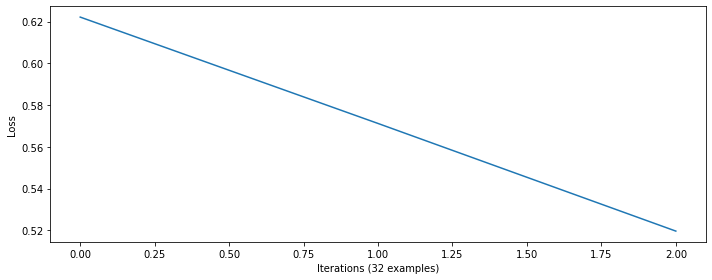

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
# visualize the loss values
ax.plot(train_loss)
# set the labels
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations (32 examples)')
fig.tight_layout()
plt.show()

In [16]:
model = model.eval()
# batch the train data so that each batch contains 4 examples (using 'batch_size')
test_data = torch.utils.data.DataLoader(dataset['test'], batch_size=4)

In [17]:
# create the confusion matrix
confusion = torch.zeros(num_labels, num_labels)

# iterate through each batch of the train data
for i, batch in enumerate(tqdmn(test_data)):
    # do not calculate the gradients
    with torch.no_grad():
        # move the batch tensors to the same device as the model
        batch = { k: v.to(device) for k, v in batch.items() }
        # send 'input_ids', 'attention_mask' and 'labels' to the model
        outputs = model(**batch)
            
    # get the sentence lengths
    s_lengths = batch['attention_mask'].sum(dim=1)
    # iterate through the examples
    for idx, length in enumerate(s_lengths):
        # get the true values
        true_values = batch['labels'][idx][:length]
        # get the predicted values
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        # go through all true and predicted values and store them in the confusion matrix
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1

KeyboardInterrupt: 

In [18]:
# Normalize by dividing every row by its sum
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

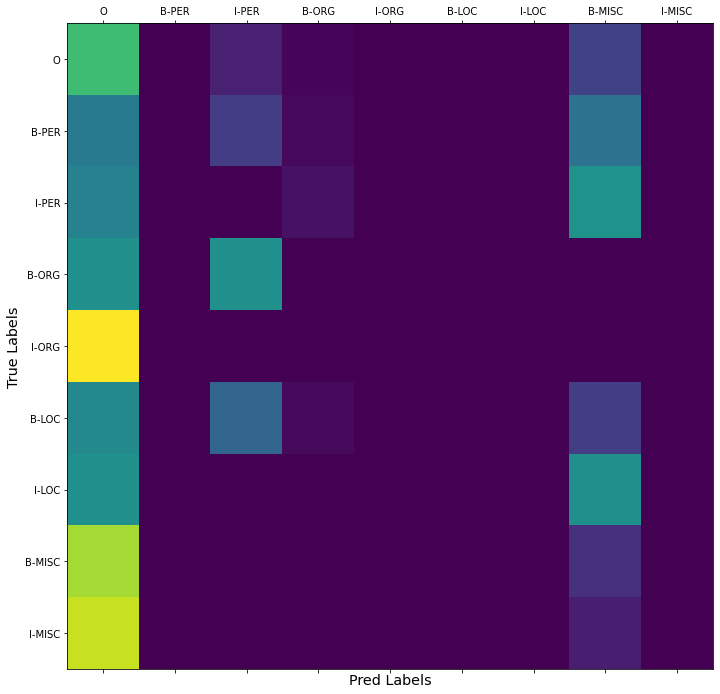

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
# visualize the loss values
ax.matshow(confusion.numpy())

# get the labels
labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

# set the x ticks
ax.set_xticks(ids)
ax.set_xticklabels(labels)

# set the y ticks
ax.set_yticks(ids)
ax.set_yticklabels(labels)

# plot figure
fig.tight_layout()
plt.show()

## 15. Test with data loading functions

In [84]:
from pathlib import Path
import re

def read_wnut(file_path):
    file_path = Path(file_path)

    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            tokens.append(token)
            tags.append(tag)
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

texts, tags = read_wnut('/home/erikt/tmp/wnut17train.conll')

In [86]:
texts[0]


['@paulwalk',
 'It',
 "'s",
 'the',
 'view',
 'from',
 'where',
 'I',
 "'m",
 'living',
 'for',
 'two',
 'weeks',
 '.',
 'Empire',
 'State',
 'Building',
 '=',
 'ESB',
 '.',
 'Pretty',
 'bad',
 'storm',
 'here',
 'last',
 'evening',
 '.']

In [87]:
tags[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-location',
 'I-location',
 'I-location',
 'O',
 'B-location',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [88]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_tags, val_tags = train_test_split(texts, tags, test_size=.2)

In [89]:
unique_tags = set(tag for doc in tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [90]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

In [96]:
import numpy as np

def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)

        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

train_labels = encode_tags(train_tags, train_encodings)
val_labels = encode_tags(val_tags, val_encodings)

In [97]:
import torch

class WNUTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings.pop("offset_mapping") # we don't want to pass this to the model
val_encodings.pop("offset_mapping")
train_dataset = WNUTDataset(train_encodings, train_labels)
val_dataset = WNUTDataset(val_encodings, val_labels)

In [98]:
from transformers import DistilBertForTokenClassification
model = DistilBertForTokenClassification.from_pretrained('distilbert-base-cased', num_labels=len(unique_tags))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

In [99]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

ValueError: Expected input batch_size (16) to match target batch_size (1440).